## Table of Contents 
1. [Introduction](#table-of-contents)
    - 1.1 [Project Description](#introduction)
    - 1.2 [Imports](#imports)
    - 1.3 [Data Dictionary](#data-dictionary)
2. [Exploratory Data Analysis](#investigation-of-features)
3. [Data Transformation](#data-transformation)
    - 3.1 [Target Variable](#1-target-variable-cancer-type)
    - 3.2 [Genomic Features](#2-genonic-features)
    - 3.3 [Patient Features](#3-patient-features)
4. [Feature Engineering](#feature-engineering)

## Introduction

The primary goal of this project is to determine the genetic and lifestyle characteristics that are most predictive of brain tumor type (between Low Grade Glioma and Glioblastoma Multiforme).

#### GOALS
* Two types of brain cancer, Glioma (GMA) and Glioblasoma (GBM).
Build a classificatin model that distinguishes beetween two types bsed on genomic data. Eg variant classification, tumor sequance, allele, model that distinguishes one type or another. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error  
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


### Data Dictionary

#### All Initial Features
| Field | Datatype | Description |
| --- | --- | --- |
| chrom | object | Chromosome
| chromStart | int64 | Start position in chromosome
| chromEnd | int64 | End position in chromosome
| name | object | Name of item
| score | int64 | Score from 0-1000
| strand | object | + or -
| thickStart | int64 | Start of where display should be thick (start codon)
| thickEnd | int64 | End of where display should be thick (stop codon)
| reserved | object | Used as itemRgb as of 2004-11-22
| blockCount | int64 | Number of blocks
| blockSizes | int64 | Comma separated list of block sizes
| chromStarts | int64 | Start positions relative to chromStart
| sampleCount | int64 | Number of samples with this variant
| freq | float64 | Variant frequency
| Hugo_Symbol | object | Symbol / nomenclature to identify each gene 
| Entrez_Gene_Id | int64 | Entrez Gene Id
| Variant_Classification | object | Class of variant
| Variant_Type | object | Type of variant
| Reference_Allele | object | Reference allele
| Tumor_Seq_Allele1 | object | Tumor allele 1
| Tumor_Seq_Allele2 | object | Tumor allele 2
| dbSNP_RS | object | dbSNP RS number
| dbSNP_Val_Status | object | dbSNP validation status
| days_to_death | object | Number of days till death
| cigarettes_per_day | object | Number of cigarettes per day
| weight | object | Weight
| alcohol_history | object | Any alcohol consumption?
| alcohol_intensity | object | Frequency of alcohol consumption
| bmi | object | Body mass index
| years_smoked | object | Number of years smoked
| height | object | Height
| gender | object | Gender
| project_id | object | TCGA Project id
| ethnicity | object | Ethnicity
| Tumor_Sample_Barcode | object |  Tumor sample barcode
| Matched_Norm_Sample_Barcode | object | Matched normal sample barcode
| case_id | object | Case ID 
| cancer_type | object | Low Grade Glioma (LGG) / Gliomablastoma (GBM)

#### Dropped Columns
* 'reserved'
    - There is only one value for this feature
* 'Tumor_Sample_Barcode'
    - This feature is not relevant for modelling
* 'Matched_Norm_Sample_Barcode'
    - This feature is not relevant for modelling
* 'case_id'
    - This feature is not relevant for modelling
* 'project_id'
    - This feature is not relevant for modelling

# Included Features

#### Genomic Location Information 
| Feature | Description |
| --- | --- |
| chrom | Chromosome where the mutation is located (e.g. "chr1") |
| chromStart & chromEnd | Precise position of the mutation on hte chromosome |
| name | Simple description of the mutation (e.g., "C>T" means a C base was changed to a T) |
| strand | DNA strand information (indicated by ".") |

#### Mutation Details
| Feature | Description |
| --- | --- |
| Hugo_Symbol | Gene name affected by this mutation (e.g., "OR4F5", "MIR6723"). The Hugo symbol is the standard nomenclature for genes. |
| Variant_Classification | Type of mutation effect (e.g., "Silent" means it doesn't change the protein) |
| Variant_Type | Type of genetic change (SNP = Single Nucleotide Polymorphism) |
| Reference_Allele | The original DNA base at this position | 
| Tumor_Seq_Allele1 & Tumor_Seq_Allele2 | The observed DNA bases in the tumor |

In [4]:
cancer_df = pd.read_csv('data/somatic_variant_data.csv')

In [5]:
cancer_df.shape

(118321, 38)

In [6]:
cancer_df.head()

,"#""chrom""",chromStart,chromEnd,name,score,strand,thickStart,thickEnd,reserved,blockCount,...,bmi,years_smoked,height,gender,project_id,ethnicity,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,case_id,cancer_type
0,chr1,69665,69666,C>T,1,.,69665,69666,"0,0,0",1,...,--,--,--,female,TCGA-GBM,not hispanic or latino,TCGA-19-5956-01A-11D-1696-08,TCGA-19-5956-10A-01D-1696-08,7e70a318-3acc-42f3-8287-158a2199f0bc,GBM
1,chr1,634047,634048,G>A,1,.,634047,634048,"0,0,0",1,...,--,--,--,male,TCGA-GBM,not hispanic or latino,TCGA-06-1800-01A-01W-0643-08,TCGA-06-1800-10A-01W-0643-08,b1ce95bf-7441-4aac-8131-19a177d2b8ac,GBM
2,chr1,874213,874214,C>T,1,.,874213,874214,"0,0,0",1,...,--,--,--,female,TCGA-LGG,not hispanic or latino,TCGA-DU-6392-01A-11D-1705-08,TCGA-DU-6392-10A-01D-1705-08,fcd9e1c4-bddb-4856-844c-03df48fba499,LGG
3,chr1,874359,874360,T>G,1,.,874359,874360,"0,0,0",1,...,--,--,--,female,TCGA-GBM,not hispanic or latino,TCGA-06-5416-01A-01D-1486-08,TCGA-06-5416-10A-01D-1486-08,3a3fc890-1985-4353-861b-dc3abfb364b1,GBM
4,chr1,925927,925928,G>C,1,.,925927,925928,"0,0,0",1,...,--,--,--,male,TCGA-LGG,not hispanic or latino,TCGA-HW-7490-01A-11D-2024-08,TCGA-HW-7490-10A-01D-2024-08,c3c41fd2-f0d7-4f46-9e18-cce4626538c2,LGG


In [7]:
# Count all the missing values in the DataFrame
cancer_df.isnull().sum()

#"chrom"                           0
chromStart                         0
chromEnd                           0
name                               0
score                              0
strand                             0
thickStart                         0
thickEnd                           0
reserved                           0
blockCount                         0
blockSizes                         0
chromStarts                        0
sampleCount                        0
freq                               0
Hugo_Symbol                        0
Entrez_Gene_Id                     0
Variant_Classification             0
Variant_Type                       0
Reference_Allele                   0
Tumor_Seq_Allele1                  0
Tumor_Seq_Allele2                  0
dbSNP_RS                       20171
dbSNP_Val_Status               97248
days_to_death                      0
cigarettes_per_day                 0
weight                             0
alcohol_history                    0
a

In [8]:
# look at the two features with missing values
cancer_df[['dbSNP_RS', 'dbSNP_Val_Status']].head()

,dbSNP_RS,dbSNP_Val_Status
0,novel,NaN
1,NaN,NaN
2,novel,NaN
3,novel,NaN
4,novel,NaN


In [9]:
cancer_df['dbSNP_RS'].value_counts()

dbSNP_RS
novel          70425
rs121913500      374
rs121913343       50
rs121913499       27
rs139236063       17
               ...  
rs780611504        1
rs778051530        1
rs142559400        1
rs77327288         1
rs777620757        1
Name: count, Length: 26461, dtype: int64

In [10]:
cancer_df['dbSNP_Val_Status'].value_counts()

dbSNP_Val_Status
byFrequency                                             7667
byCluster;byFrequency                                   3838
byCluster                                               2721
by1000G;byCluster                                       2526
by1000G;byCluster;byFrequency                           2347
by1000G                                                 1449
by1000G;byFrequency                                      414
by1000G;byCluster;byFrequency;byHapMap                    40
byCluster;byFrequency;byHapMap                            18
byCluster;byHapMap                                        14
byHapMap                                                   7
by1000G;byCluster;byFrequency;suspect                      7
by1000G;byCluster;byHapMap                                 5
byCluster;suspect                                          5
by1000G;byCluster;suspect                                  3
suspect                                                    2
byClust

Although these rows have missing values, they are not useful for our analysis


In [11]:
cancer_df1 = cancer_df.drop(['dbSNP_RS', 'dbSNP_Val_Status'], axis=1)
cancer_df1.isnull().sum()

#"chrom"                       0
chromStart                     0
chromEnd                       0
name                           0
score                          0
strand                         0
thickStart                     0
thickEnd                       0
reserved                       0
blockCount                     0
blockSizes                     0
chromStarts                    0
sampleCount                    0
freq                           0
Hugo_Symbol                    0
Entrez_Gene_Id                 0
Variant_Classification         0
Variant_Type                   0
Reference_Allele               0
Tumor_Seq_Allele1              0
Tumor_Seq_Allele2              0
days_to_death                  0
cigarettes_per_day             0
weight                         0
alcohol_history                0
alcohol_intensity              0
bmi                            0
years_smoked                   0
height                         0
gender                         0
project_id

The features with missing values have been dropped.

In [12]:
# Check for duplicates
cancer_df1.duplicated().sum()

np.int64(0)

In [13]:
cancer_df['score']

0         1
1         1
2         1
3         1
4         1
         ..
118316    1
118317    1
118318    1
118319    1
118320    1
Name: score, Length: 118321, dtype: int64

There are no duplicate rows found in this dataframe.

The following features are dropped because the do not afford data that is useful for modelling. They contain sample id info used for organization of the samples rather than for modelling. 

In [14]:
# drop the following columns
cancer_df1 = cancer_df1.drop(['case_id', 'Matched_Norm_Sample_Barcode', 'Tumor_Sample_Barcode'], axis=1)

### Investigation of Features

In [15]:
cancer_df1['name'].value_counts()

name
G>A                    28471
C>T                    28093
G>T                     9669
C>A                     9657
T>C                     6990
                       ...  
insAGAAAAACACAAGAAT        1
insGACAGAGTGAGACTC         1
insGATTGATG                1
insAAG                     1
insTCTATTTTTAT             1
Name: count, Length: 1410, dtype: int64

In [16]:
cancer_df1['Hugo_Symbol'].value_counts()

Hugo_Symbol
TTN             478
TP53            429
IDH1            414
ATRX            244
MUC16           176
               ... 
DOHH              1
RP11-38C17.1      1
SDF4              1
FAM132A           1
UBE2J2            1
Name: count, Length: 18113, dtype: int64

The Hugo symbol is nomenclature used to identify genes. 

In [17]:
cancer_df1['reserved'].value_counts()

reserved
0,0,0    118321
Name: count, dtype: int64

In [18]:
# Sincnne the 'reserved' column has only one value, we can drop it
cancer_df1 = cancer_df1.drop('reserved', axis=1)

In [19]:
cancer_df1['Reference_Allele'].value_counts()

Reference_Allele
G                                     42458
C                                     41970
T                                     15292
A                                     14380
-                                      2879
                                      ...  
TCGCCTGTTAATTTTCTAAAAATAA                 1
GAGCAGATGTTGGTAAAGAGTCAAAGGCAGGAGA        1
CACGAAGGACTTGGTA                          1
AAGATCTGTTTACGTGA                         1
AGCTCGCTACTATAAA                          1
Name: count, Length: 529, dtype: int64

In [20]:
cancer_df1['Reference_Allele'].nunique()

529

In [21]:
cancer_df1['Hugo_Symbol'].nunique()

18113

Reference Allele
* The DNA base that is the standard sequence of a nucleotide (base) at a specific location in the reference genome (established sequence of DNA used to represent the standard version of the human genome). 

Hugo Symbol
* Standard nomenclature used to identify genes. 18,113 of the 47,977 HUGO symbols are found in this dataset. 

Ordinal encoding? Creating a class system?

In [22]:
cancer_df1['cancer_type'].value_counts()

cancer_type
GBM    82765
LGG    35556
Name: count, dtype: int64

<Axes: title={'center': 'Cancer Type Counts'}, xlabel='cancer_type'>

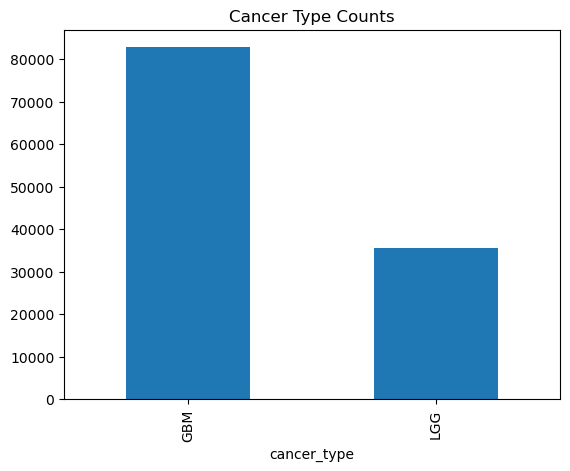

In [23]:
cancer_df1['cancer_type'].value_counts().plot(kind='bar',
                                                   title='Cancer Type Counts')

Because there are only two values in the target variable, binary encoding will suffice. 

In [24]:
cancer_df['Variant_Classification'].value_counts()


Variant_Classification
Missense_Mutation         68430
Silent                    23974
Nonsense_Mutation          5099
3'UTR                      4839
Intron                     4068
Frame_Shift_Del            2384
Frame_Shift_Ins            1887
5'UTR                      1874
RNA                        1646
Splice_Site                1384
Splice_Region              1061
3'Flank                     500
5'Flank                     466
In_Frame_Del                293
In_Frame_Ins                261
Translation_Start_Site       85
Nonstop_Mutation             64
IGR                           6
Name: count, dtype: int64

There are 19 types of Variant Classification

In [25]:
cancer_df['Variant_Type'].value_counts()

Variant_Type
SNP    112187
DEL      3255
INS      2879
Name: count, dtype: int64

* SNP (single nucleotide polymorphism): 
    - When one nucleotide (A, T, C, G) in a DNA sequence differs from a referene sequence. 
* DEL (deletion): 
    - Where a segment of DNA is lost or removed from its normal position in the genome.
* INS (insertion): 
    - Where one or more nucleotides are added to a DNA sequence.

Drop the 'strand' and 'reserved' columns as they have only one data value

In [26]:
cancer_df1 = cancer_df.drop(['strand',
                            'reserved',
                            'case_id', 
                            'Matched_Norm_Sample_Barcode', 
                            'Tumor_Sample_Barcode'], axis=1)
                            
                            

In [27]:
cancer_df1.head()

,"#""chrom""",chromStart,chromEnd,name,score,thickStart,thickEnd,blockCount,blockSizes,chromStarts,...,weight,alcohol_history,alcohol_intensity,bmi,years_smoked,height,gender,project_id,ethnicity,cancer_type
0,chr1,69665,69666,C>T,1,69665,69666,1,1,0,...,--,--,--,--,--,--,female,TCGA-GBM,not hispanic or latino,GBM
1,chr1,634047,634048,G>A,1,634047,634048,1,1,0,...,--,--,--,--,--,--,male,TCGA-GBM,not hispanic or latino,GBM
2,chr1,874213,874214,C>T,1,874213,874214,1,1,0,...,--,--,--,--,--,--,female,TCGA-LGG,not hispanic or latino,LGG
3,chr1,874359,874360,T>G,1,874359,874360,1,1,0,...,--,--,--,--,--,--,female,TCGA-GBM,not hispanic or latino,GBM
4,chr1,925927,925928,G>C,1,925927,925928,1,1,0,...,--,--,--,--,--,--,male,TCGA-LGG,not hispanic or latino,LGG


# Data Transformation

### 1. Target Variable (Cancer Type)
 - Binary encode (LGG -> 0, GBM -> 1)

In [28]:
cancer_df1['cancer_type'].value_counts()

cancer_type
GBM    82765
LGG    35556
Name: count, dtype: int64

In [29]:
# Binary encode the cancer_type column LGG = 0, GBM = 1
cancer_df1['cancer_type'] = cancer_df1['cancer_type'].apply(lambda x: 0 if x == 'LGG' else 1)

In [30]:
# Check to see if the encoding was successful
cancer_df1['cancer_type'].value_counts()

cancer_type
1    82765
0    35556
Name: count, dtype: int64

### 2. Genonic Features

#### 'chrom' 
 - one-hot encode chromosomes (chr1, chr2, etc.)

In [31]:
# Change the "chrom" column to name to chrom
cancer_df1 = cancer_df1.rename(columns={'#"chrom"' : 'chrom'})

In [32]:
# One hot encode the chromosome column
cancer_df1 = pd.get_dummies(cancer_df1, columns=['chrom'],
                            dtype=int,
                            drop_first=True)

In [33]:
# check to see if the encoding was successful
cancer_df1.head()

,chromStart,chromEnd,name,score,thickStart,thickEnd,blockCount,blockSizes,chromStarts,sampleCount,...,chrom_chr22,chrom_chr3,chrom_chr4,chrom_chr5,chrom_chr6,chrom_chr7,chrom_chr8,chrom_chr9,chrom_chrX,chrom_chrY
0,69665,69666,C>T,1,69665,69666,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,634047,634048,G>A,1,634047,634048,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,874213,874214,C>T,1,874213,874214,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,874359,874360,T>G,1,874359,874360,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,925927,925928,G>C,1,925927,925928,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


#### 'Variant_Classification'
 - one-hot encode (Silent, Missense, Nonsense, etc.)

In [34]:
cancer_df1['Variant_Classification'].value_counts()

Variant_Classification
Missense_Mutation         68430
Silent                    23974
Nonsense_Mutation          5099
3'UTR                      4839
Intron                     4068
Frame_Shift_Del            2384
Frame_Shift_Ins            1887
5'UTR                      1874
RNA                        1646
Splice_Site                1384
Splice_Region              1061
3'Flank                     500
5'Flank                     466
In_Frame_Del                293
In_Frame_Ins                261
Translation_Start_Site       85
Nonstop_Mutation             64
IGR                           6
Name: count, dtype: int64

In [35]:
# create dummy variables for the 'Variant_Classification' column
cancer_df1 = pd.get_dummies(cancer_df1, columns=['Variant_Classification'],
                            dtype=int,
                            drop_first=True)

In [36]:
# check to see if the encoding was successful
cancer_df1.head()

,chromStart,chromEnd,name,score,thickStart,thickEnd,blockCount,blockSizes,chromStarts,sampleCount,...,Variant_Classification_In_Frame_Ins,Variant_Classification_Intron,Variant_Classification_Missense_Mutation,Variant_Classification_Nonsense_Mutation,Variant_Classification_Nonstop_Mutation,Variant_Classification_RNA,Variant_Classification_Silent,Variant_Classification_Splice_Region,Variant_Classification_Splice_Site,Variant_Classification_Translation_Start_Site
0,69665,69666,C>T,1,69665,69666,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1,634047,634048,G>A,1,634047,634048,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,874213,874214,C>T,1,874213,874214,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,874359,874360,T>G,1,874359,874360,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,925927,925928,G>C,1,925927,925928,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


#### ' Variant_Type'
 - One-hot encode (SNP, INS, DEL, etc.)

In [37]:
cancer_df1['Variant_Type'].value_counts()

Variant_Type
SNP    112187
DEL      3255
INS      2879
Name: count, dtype: int64

In [38]:
# Create dummy variables for the 'Variant_Type' feature
cancer_df1 = pd.get_dummies(cancer_df1, columns=['Variant_Type'],
                            dtype=int,
                            drop_first=True)

#### 'Hugo_Symbol'
 - Frequency encoding (how common each gene is)

In [39]:
cancer_df1['Hugo_Symbol'].value_counts()

Hugo_Symbol
TTN             478
TP53            429
IDH1            414
ATRX            244
MUC16           176
               ... 
DOHH              1
RP11-38C17.1      1
SDF4              1
FAM132A           1
UBE2J2            1
Name: count, Length: 18113, dtype: int64

Since there are so many different unique Hugo_Symbol values we will drop the column

In [40]:
cancer_df1 = cancer_df1.drop('Hugo_Symbol', axis=1)

### 3. Patient Features


### Gender
 - Binary encod the 'gender' feature (female -> 0, male -> 1)

In [41]:
# Binary encode the 'gender' feature
cancer_df1['gender'] = cancer_df1['gender'].apply(lambda x: 0 if x == 'female' else 1)

In [42]:
cancer_df1['gender'].value_counts()

gender
0    70054
1    48267
Name: count, dtype: int64

# Feature Engineering

chromStart, chromEnd: Use as is, but consider:
 - Chromosome-normalized position (position + chromosome length)
 - Distance from centromere or telomere


## 1. Genomic Context Features

### Mutation Length 
- mutation_length = chromEnd - chromStart

In [ ]:
# Create a new feature called 'mutation_length'
# which is the difference between the chrromEnd and chromStart columns

cancer_df1['mutation_length'] = cancer_df1['chromEnd'] - cancer_df1['chromStart']
cancer_df1['mutation_length'].value_counts()

### Exonic 
 -  is_exonic (boolean): Flag if mutation is in a protein-coding region

In [48]:
cancer_df1['Reference_Allele'].nunique()

529

### Gene Family
 - Group genes by biological function/family

### Chromosome Group 
 - Group chromosomes (sex chromosomes vs. autosomes)


## 2. Mutation Characteristics

### Transition vs Transversion
 - Flag for mutation type (transitions are A>G or C>T)


### CpG Site
 - Flag if mutation occurs at a CpG site (often hypermutable)

### Functional Impact
 - Combine Variant_Classification into severity groups


In [50]:
cancer_df1['Variant_Classification'] = cancer_df['Variant_Classification']

In [51]:
cancer_df1['Variant_Classification'].value_counts()

Variant_Classification
Missense_Mutation         68430
Silent                    23974
Nonsense_Mutation          5099
3'UTR                      4839
Intron                     4068
Frame_Shift_Del            2384
Frame_Shift_Ins            1887
5'UTR                      1874
RNA                        1646
Splice_Site                1384
Splice_Region              1061
3'Flank                     500
5'Flank                     466
In_Frame_Del                293
In_Frame_Ins                261
Translation_Start_Site       85
Nonstop_Mutation             64
IGR                           6
Name: count, dtype: int64

#### Severe / Serious
* Missense Mutation
    - A type of point mutation
* Silent
    - 

#### 

#### 

## 3. Advanced Genomic Features

### Gene Expression Cluster
 - If you have gene expression data


### Mutation Burden
 - mutation_burden: Count of mutations per patient


### Pathway Impact
 - pathway_impact: Aggregate mutations by biological pathway

## Interaction Features
 - gender × gene: Some mutations have gender-specific effects 

# Modelling

### Logistic Regression Model

1. Split the data
    - Divide the dataset into training and test sets (80:20 ratio).
2. Scaling parameters
    - Standard Scaler will be used
3. Scale the Training Data
    - Apply the scaling transformation to the training data
4. Fit the model
    - Train the model using the scaled training data
5. Scale the test data
    - Scale the test data before making predictions. 
6. Evaluate model performance
    - Using the scaled test data, evaluate the model's performance (accuracy, precision, recall, F1-score)

* Regularization: Lasso regularization will be used
* Scaler: StandardScaler will be used

In [3]:
# create a logistic regression model
X = cancer_df1.drop('cancer_type', axis=1)
y = cancer_df1['cancer_type']

NameError: name 'cancer_df1' is not defined

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'X' is not defined

In [4]:
# Instantiate the model
model = LogisticRegression()
model.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [
            {'model': [LogisticRegression()], 
             'normalise': [StandardScaler(), None],
             'model__penalty': ['l1', 'l2'],
             'model__solver': ['saga', 'liblinear'],
             'model__C': [0.001, 0.01, 0.1, 1, 10, 15]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X_train, y_train)